<a href="https://colab.research.google.com/github/sumukhig/Implementing-CutLER/blob/main/Implementing_CutLER_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install cython
! pip install transformers
! pip install colored
! pip install git+https://github.com/lucasb-eyer/pydensecrf.git
! pip install git+https://github.com/facebookresearch/detectron2.git
! pip install git+https://github.com/cocodataset/panopticapi.git
! pip install git+https://github.com/mcordts/cityscapesScripts.git
! pip install git+https://git@github.com:facebookresearch/CutLER.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-m71t_roe
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-m71t_roe
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/

# **Maskcut** - Code for mask generation

In [ ]:
import os
import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as VF

MAX_ITER = 10
POS_W = 7 
POS_XY_STD = 3
Bi_W = 10
Bi_XY_STD = 50 
Bi_RGB_STD = 5

def densecrf(image, mask):
    h, w = mask.shape
    mask = mask.reshape(1, h, w)
    fg = mask.astype(float) 
    bg = 1 - fg
    output_logits = torch.from_numpy(np.concatenate((bg,fg), axis=0))

    H, W = image.shape[:2]
    image = np.ascontiguousarray(image)
    
    output_logits = F.interpolate(output_logits.unsqueeze(0), size=(H, W), mode="bilinear").squeeze()
    output_probs = F.softmax(output_logits, dim=0).cpu().numpy()

    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=image, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    MAP = np.argmax(Q, axis=0).reshape((h,w)).astype(np.float32)
    return MAP

In [ ]:
import numpy as np
from PIL import Image
#from datasets import load_dataset
import tensorflow as tf
from transformers import TFViTModel
from scipy.linalg import eigh
from scipy import ndimage
# from crf import densecrf
# from torch_crf import densecrf
import matplotlib.pyplot as plt

def detect_box(bipartition, seed,  dims, initial_im_size=None, scales=None, principle_object=True):

    w_featmap, h_featmap = dims
    objects, num_objects = ndimage.label(bipartition)
    cc = objects[np.unravel_index(seed, dims)]


    if principle_object:
        mask = np.where(objects == cc)
       # Add +1 because excluded max
        ymin, ymax = min(mask[0]), max(mask[0]) + 1
        xmin, xmax = min(mask[1]), max(mask[1]) + 1
        # Rescale to image size
        r_xmin, r_xmax = scales[1] * xmin, scales[1] * xmax
        r_ymin, r_ymax = scales[0] * ymin, scales[0] * ymax
        pred = [r_xmin, r_ymin, r_xmax, r_ymax]

        # Check not out of image size (used when padding)
        if initial_im_size:
            pred[2] = min(pred[2], initial_im_size[1])
            pred[3] = min(pred[3], initial_im_size[0])

        # Coordinate predictions for the feature space
        # Axis different then in image space
        pred_feats = [ymin, xmin, ymax, xmax]

        return pred, pred_feats, objects, mask
    else:
        raise NotImplementedError
             
def IoU(mask1, mask2):
    threshold = 0.5
    mask1, mask2 = tf.where(mask1 > threshold, 1, 0), tf.where(mask2 > threshold, 1, 0)
    intersection = tf.squeeze(tf.reduce_sum(tf.cast(mask1 * tf.cast(mask1==mask2, tf.int32), tf.float32), axis=[-1, -2]))
    union = tf.squeeze(tf.reduce_sum(tf.cast(mask1 + mask2, tf.float32), axis=[-1, -2]))
    return tf.reduce_mean(intersection / union).numpy()

def get_mean_and_std(x):
    mm, var=tf.nn.moments(x,axes=[0,1])
    return mm, var

def resize_pil(I, patch_size=16) : 
    w, h = I.size

    new_w, new_h = int(round(w / patch_size)) * patch_size, int(round(h / patch_size)) * patch_size
    feat_w, feat_h = new_w // patch_size, new_h // patch_size

    return I.resize((new_w, new_h), resample=Image.LANCZOS), w, h, feat_w, feat_h
    

def vit_small(patch_size=16, **kwargs):
    if patch_size == 8:
        model = TFViTModel.from_pretrained('facebook/dino-vits8', from_pt = True)
    elif patch_size == 16:
        model = TFViTModel.from_pretrained('facebook/dino-vits16', from_pt = True)
    return model


def vit_base(patch_size=16, **kwargs):
    if patch_size == 8:
        model = TFViTModel.from_pretrained('facebook/dino-vitb8', from_pt = True)
    elif patch_size == 16:
        model = TFViTModel.from_pretrained('facebook/dino-vitb16', from_pt = True)
    return model


class ViTFeat(tf.keras.Model):
    """ Vision Transformer """
    def __init__(self, feat_dim, vit_arch='base', vit_feat='k', patch_size=16):
        super().__init__()

        if vit_arch == 'base':
            model_name = 'facebook/dino-vit-base'
            model = vit_base(patch_size=patch_size)
        else:
            model_name = 'facebook/dino-vit-small'
            model = vit_small(patch_size=patch_size)

        self.model = model
        self.feat_dim = feat_dim
        self.vit_feat = vit_feat
        self.patch_size = patch_size

    def call(self, img):
        feat_out = {}
        outputs = self.model(img, output_attentions = True, output_hidden_states = True)

        # feat_out['qkv'] = tf.stack([self.model.layers[-1].encoder.layer[-1].attention.self_attention.query(inputs = outputs.last_hidden_state),
        # self.model.layers[-1].encoder.layer[-1].attention.self_attention.key(inputs = outputs.last_hidden_state),
        # self.model.layers[-1].encoder.layer[-1].attention.self_attention.value(inputs = outputs.last_hidden_state)])
        layerInput = self.model.vit.encoder.layer[-1].layernorm_before(outputs.hidden_states[-1])
        raw_q = self.model.vit.encoder.layer[11].attention.self_attention.query(layerInput)[0]
        raw_k = self.model.vit.encoder.layer[11].attention.self_attention.key(layerInput)[0]
        raw_v = self.model.vit.encoder.layer[11].attention.self_attention.value(layerInput)[0]

        feat_out['qkv'] = tf.expand_dims(tf.concat([tf.concat([raw_q, raw_k], axis=1), raw_v], axis=1), 0)

        # feat_out['qkv'] = tf.stack([self.model.vit.encoder.layer[-1].attention.self_attention.query(inputs = inputs),
        #                             self.model.vit.encoder.layer[-1].attention.self_attention.key(inputs = inputs),
        #                             self.model.vit.encoder.layer[-1].attention.self_attention.value(inputs = inputs)])

        # Forward pass in the model
        
        bs, nb_head, nb_token, _ = outputs.attentions[-1].shape
        qkv = tf.transpose(tf.reshape(feat_out['qkv'], (bs, nb_token, 3, nb_head, -1)), (2, 0, 3, 1, 4))
        q, k, v = qkv[0], qkv[1], qkv[2]

        # k = tf.linalg.matmul(outputs.attentions[-1], outputs.last_hidden_state)
        
        q = tf.reshape(tf.transpose(q, perm=[0, 2, 1, 3]), (bs, nb_token, -1))
        k = tf.reshape(tf.transpose(k, perm=[0, 2, 1, 3]), (bs, nb_token, -1))
        v = tf.reshape(tf.transpose(v, perm=[0, 2, 1, 3]), (bs, nb_token, -1))

        h, w = img.shape[2], img.shape[3]
        feat_h, feat_w = h // self.patch_size, w // self.patch_size

        if self.vit_feat == "k":
            feats = tf.reshape(tf.transpose(k[:, 1:], perm=[0, 2, 1]), (bs, self.feat_dim, feat_h * feat_w))
        elif self.vit_feat == "q":
            feats = tf.reshape(tf.transpose(q[:, 1:], perm=[0, 2, 1]), (bs, self.feat_dim, feat_h * feat_w))
        elif self.vit_feat == "v":
            feats = tf.reshape(tf.transpose(v[:, 1:], perm=[0, 2, 1]), (bs, self.feat_dim, feat_h * feat_w))
        elif self.vit_feat == "kqv":
            k = tf.transpose(k[:, 1:], perm=[0, 2, 1])
            q = tf.transpose(q[:, 1:], perm=[0, 2, 1])
            v = tf.transpose(v[:, 1:], perm=[0, 2, 1])
            feats = tf.reshape(tf.concat([k, q, v], axis=1), (bs, self.feat_dim, feat_h * feat_w))

        return feats

def get_affinity_matrix(feats, tau, eps=1e-5):
    # get affinity matrix via measuring patch-wise cosine similarity
    feats = tf.math.l2_normalize(feats, axis=0)
    A = tf.matmul(feats, feats, transpose_a=True).numpy()
    # convert the affinity matrix to a binary one.
    A = A > tau
    A = tf.where(tf.dtypes.cast(A, tf.float32) == 0, eps, A)
    d_i = tf.reduce_sum(tf.dtypes.cast(A, tf.float32), axis=1)
    D = tf.linalg.diag(d_i)
    return A, D

def second_smallest_eigenvector(A, D):
    # get the second smallest eigenvector from affinity matrix
    _, eigenvectors = eigh(D-A, D, subset_by_index=[1,2])
    eigenvec = np.copy(eigenvectors[:, 0])
    second_smallest_vec = eigenvectors[:, 0]
    return eigenvec, second_smallest_vec

def get_salient_areas(second_smallest_vec):
    # get the area corresponding to salient objects.
    avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
    bipartition = second_smallest_vec > avg
    return bipartition

def check_num_fg_corners(bipartition, dims):
    # check number of corners belonging to the foreground
    bipartition_ = bipartition.reshape(dims)
    top_l, top_r, bottom_l, bottom_r = bipartition_[0][0], bipartition_[0][-1], bipartition_[-1][0], bipartition_[-1][-1]
    nc = int(top_l) + int(top_r) + int(bottom_l) + int(bottom_r)
    return nc

def get_masked_affinity_matrix(painting, feats, mask, ps):
    # mask out affinity matrix based on the painting matrix 
    dim, num_patch = feats.shape[0], feats.shape[1]
    painting = painting + tf.expand_dims(mask, 0)
    painting = tf.where(painting > 0, 1, 0)
    feats = tf.cast(tf.reshape(feats, [dim, ps, ps]), tf.float32)
    feats = tf.reshape(feats * tf.cast(1 - painting, tf.float32), [dim, num_patch])
    painting = tf.cast(painting, tf.float64)
    return feats, painting

def maskcut_forward(feats, dimensions, scales, init_image_size, tau=0, N=3):
    bipartitions = []
    eigvecs = []

    for i in range(N):
        print('mask_forward i=', i)
        if i == 0:
            painting = np.zeros(dimensions)
            painting = tf.convert_to_tensor(painting)
        else:
            feats, painting = get_masked_affinity_matrix(painting, feats, current_mask, ps)
        
        # construct the affinity matrix
        A, D = get_affinity_matrix(feats, tau)
        # get the second smallest eigenvector
        eigenvec, second_smallest_vec = second_smallest_eigenvector(A, D)
        # get salient area
        bipartition = get_salient_areas(second_smallest_vec)
        # check if we should reverse the partition based on:
        # 1) peak of the 2nd smallest eigvec 2) object centric bias
        seed = np.argmax(np.abs(second_smallest_vec))
        nc = check_num_fg_corners(bipartition, dimensions)
        # print(nc)
        if nc >= 3:
            reverse = True
        else:
            reverse = bipartition[seed] != 1

        if reverse:
            # reverse bipartition, eigenvector and get new seed
            eigenvec = eigenvec * -1
            bipartition = np.logical_not(bipartition)
            seed = np.argmax(eigenvec)
        else:
            seed = np.argmax(second_smallest_vec)
        
        # get pixels corresponding to the seed
        bipartition = bipartition.reshape(dimensions).astype(int)
        _, _, _, cc = detect_box(bipartition, seed, dimensions, scales=scales, initial_im_size=init_image_size)
        pseudo_mask = np.zeros(dimensions)
        pseudo_mask[cc[0],cc[1]] = 1
        pseudo_mask = tf.convert_to_tensor(pseudo_mask)
        ps = pseudo_mask.shape[0]

        # check if the extra mask is heavily overlapped with the previous one or is too small.
        if i >= 1:
            ratio = tf.cast(tf.reduce_sum(pseudo_mask), tf.float32) / tf.cast(pseudo_mask.shape[0]*pseudo_mask.shape[1], tf.float32)
            if IoU(current_mask, pseudo_mask) > 0.5 or ratio <= 0.01:
                pseudo_mask = np.zeros(dimensions)
                pseudo_mask = tf.convert_to_tensor(pseudo_mask)
        
        current_mask = pseudo_mask

        # mask out foreground areas in previous stages
        masked_out = 0 if len(bipartitions) == 0 else np.sum(bipartitions, axis=0)
        bipartition = tf.squeeze(tf.image.resize(tf.expand_dims(tf.expand_dims(pseudo_mask, 0), -1), size=init_image_size, method='nearest'))
        bipartition_masked = bipartition.numpy() - masked_out
        bipartition_masked[bipartition_masked <= 0] = 0
        bipartitions.append(bipartition_masked)

        # unsample the eigenvec
        eigvec = second_smallest_vec.reshape(dimensions)
        eigvec = tf.convert_to_tensor(eigvec)
        eigvec = tf.squeeze(tf.image.resize(tf.expand_dims(tf.expand_dims(eigvec, 0), -1), size=init_image_size, method='nearest'))
        eigvecs.append(eigvec.numpy())

    return seed, bipartitions, eigvecs
    
def maskcut(img_path, backbone, patch_size, tau, N, fixed_size):
    bipartitions, eigvecs = [], []

    img = Image.open(img_path).convert('RGB')
    imgNew = img.resize((int(fixed_size), int(fixed_size)), Image.LANCZOS)
    imgResize, w, h, feat_w, feat_h = resize_pil(imgNew, patch_size)
    imgTensor = tf.cast(tf.convert_to_tensor(imgResize), tf.float32)
    imgTensor = imgTensor / 255.0
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    imgTensor = (imgTensor - mean) / std
    imgTensor = tf.transpose(imgTensor, perm=[2,0,1])
    # imgTensor = tf.reshape(tf.expand_dims(imgTensor, 0), (1, 3, h, w))
    imgTensor = tf.expand_dims(imgTensor, 0)

    feat = backbone(imgTensor)[0]

    _, bipartition, eigvec = maskcut_forward(feat, [feat_h, feat_w], [patch_size, patch_size], [h,w], tau, N=N)

    bipartitions += bipartition
    eigvecs += eigvec

    return bipartitions, eigvecs, imgNew

def vis_mask(input, mask, mask_color) :
    fg = mask > 0.5
    rgb = np.copy(input)
    rgb[fg] = (rgb[fg] * 0.3 + np.array(mask_color) * 0.7).astype(np.uint8)
    return Image.fromarray(rgb)

In [ ]:
def generate_mask_cut(img_path):
    fixed_size = 224
    patch_size = 8
    vit_arch = 'base'
    vit_feat = 'k'
    tau = 0.15
    N = 6

    if vit_arch == 'base' and patch_size == 8:
        feat_dim = 768
    elif vit_arch == 'small' and patch_size == 8:
        feat_dim = 384

    backbone = ViTFeat(feat_dim, vit_arch, vit_feat, patch_size)
     
    bipartitions, _, imgNew = maskcut(img_path, backbone, patch_size, tau, N, fixed_size)

    pseudo_mask_list = []
    I = Image.open(img_path).convert('RGB')
    width, height = I.size

    for idx, bipartition in enumerate(bipartitions):
        # post-process pesudo-masks with CRF

        pseudo_mask = densecrf(np.array(imgNew), bipartition)

        pseudo_mask = ndimage.binary_fill_holes(pseudo_mask>=0.5).astype(float)

        mask1 = tf.convert_to_tensor(bipartition)
        mask2 = tf.convert_to_tensor(pseudo_mask)

        # print(pseudo_mask.any())

        print(IoU(mask1, mask2))

        if IoU(mask1, mask2) < 0.4:
            pseudo_mask = pseudo_mask * -1
    
        pseudo_mask[pseudo_mask < 0] = 0

        pseudo_mask = Image.fromarray(np.uint8(pseudo_mask*255))
        pseudo_mask = np.asarray(pseudo_mask.resize((width, height)))

        pseudo_mask = pseudo_mask.astype(np.uint8)
        upper = np.max(pseudo_mask)
        lower = np.min(pseudo_mask)
        thresh = upper / 2.0
        pseudo_mask[pseudo_mask > thresh] = upper
        pseudo_mask[pseudo_mask <= thresh] = lower
        pseudo_mask_list.append(pseudo_mask)


    input = np.array(I)
    for pseudo_mask in pseudo_mask_list:
        input = vis_mask(input, pseudo_mask, [0, 255, 0])
    plt.imshow(input)

    print(len(pseudo_mask_list))
    print(type(pseudo_mask))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = '/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/demo/imgs'
"""
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    generate_mask_cut(f)
"""

'\nfor filename in os.listdir(directory):\n    f = os.path.join(directory, filename)\n    generate_mask_cut(f)\n'

# **Detector** - Code for pre-trained object detector


In [ ]:
# Import standard modules
import sys
import argparse
import tempfile
import time
import cv2
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np

# Define filepath dependancies
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CutLER/cutler')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/demo')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2')
from config import add_cutler_config
from predictor import VisualizationDemo

In our application of CutLER, we have opted to use pretrained models due to time and space constraints. CutLER provides their pretrained weights and pulls from the Detector2 library to deploy and visualize these weights.

[Detectron2](https://github.com/facebookresearch/detectron2) is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. It is the successor of Detectron and maskrcnn-benchmark. It supports a number of computer vision research projects and production applications in Facebook.


In [ ]:
# Import detectron2 packages
from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger

In [ ]:
def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_cutler_config(cfg)

    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)

    # Disable the use of SyncBN normalization when running on a CPU
    # SyncBN is not supported on CPU and can cause errors, so we switch to BN instead
    if cfg.MODEL.DEVICE == 'cpu' and cfg.MODEL.RESNETS.NORM == 'SyncBN':
        cfg.MODEL.RESNETS.NORM = "BN"
        cfg.MODEL.FPN.NORM = "BN"

    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = args.confidence_threshold
    cfg.freeze()
    
    return cfg

In [ ]:
def get_parser(inputs):
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input", help="path to the input image",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )
    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.35,
        help="Minimum score for instance predictions to be shown",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    args = parser.parse_args(inputs)
    return args

In [ ]:
# Download pretrained checkpoints
! wget http://dl.fbaipublicfiles.com/cutler/checkpoints/cutler_cascade_final.pth

--2023-04-26 02:49:30--  http://dl.fbaipublicfiles.com/cutler/checkpoints/cutler_cascade_final.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.90, 13.225.142.121, 13.225.142.76, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574672112 (548M) [binary/octet-stream]
Saving to: ‘cutler_cascade_final.pth’

cutler_cascade_fina 100%[===================>] 548.05M  29.9MB/s    in 18s     

2023-04-26 02:49:49 (29.8 MB/s) - ‘cutler_cascade_final.pth’ saved [574672112/574672112]



The function below is the driver for the pre-trained detector code.
It takes in parameters used to "load" weights and parameter into a demonstration "demo" detector. 

The config file we will be using holds the configurations of the pretrained model. In this demonstration we will be using Faster/Mask R-CNN with an FPN backone which uses a ResNet+FPN backbone with standard conv and FC heads for mask and box prediction, respectively. It obtains the best speed/accuracy tradeoff, compared to C4 and DP5 [(more info here)](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md). Input can be modified to test on your own images. You can also use a lower confidence_threshold to get a higher recall.


In [ ]:
def deploy_detecter(config_file="/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml", 
                    input="/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/demo/imgs/demo1.jpg",
                    confidence_theshold=0.5,
                    ckpt_file="cutler_cascade_final.pth"):

  # parse inputs
  mp.set_start_method("spawn", force=True)
  inputs = ['--config-file', config_file, '--input', input, '--confidence-threshold', str(confidence_theshold), "--opts", "MODEL.WEIGHTS", ckpt_file, "MODEL.DEVICE", "cpu"]
  args = get_parser(inputs)

  # detectron utilty that reads in configuration
  setup_logger(name="fvcore")
  logger = setup_logger()
  logger.info("Arguments: " + str(args))
  cfg = setup_cfg(args)

  # pulled from predictor class, visualizes results using config
  demo = VisualizationDemo(cfg)

  # use PIL, to be consistent with evaluation
  img = read_image(args.input, format="BGR")
  start_time = time.time()
  predictions, visualized_output = demo.run_on_image(img)
  logger.info(
      "{}: {} in {:.2f}s".format(
          args.input,
          "detected {} instances".format(len(predictions["instances"]))
          if "instances" in predictions
          else "finished",
          time.time() - start_time,
      )
  )

  # save image to your local directory
  if args.output:
      if os.path.isdir(args.output):
          assert os.path.isdir(args.output), args.output
          out_filename = os.path.join(args.output, os.path.basename(args.input))
      else:
          assert len(args.input) == 1, "Please specify a directory with args.output"
          out_filename = args.output
      visualized_output.save(out_filename)

  plt.imshow(visualized_output.get_image())
  plt.show()

[04/26 02:54:34 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000000.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:54:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:54:36 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/26 02:54:47 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000000.png: detected 2 instances in 9.94s


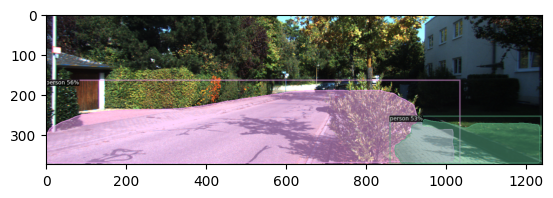

[04/26 02:54:47 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000003.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:54:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:54:48 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:54:55 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000003.png: detected 3 instances in 6.49s


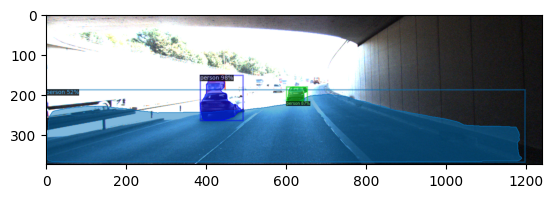

[04/26 02:54:56 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000012.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:54:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:54:58 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:06 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000012.png: detected 1 instances in 7.27s


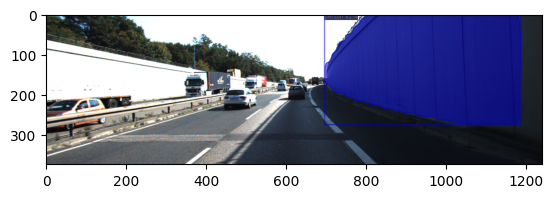

[04/26 02:55:06 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000010.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:55:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:07 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:17 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000010.png: detected 5 instances in 8.80s


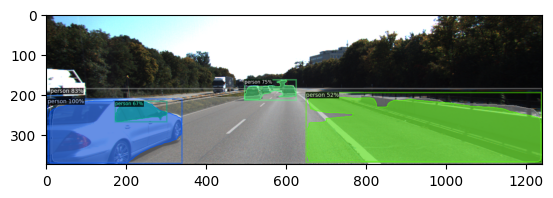

[04/26 02:55:17 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000001.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:55:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:19 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:26 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000001.png: detected 3 instances in 6.40s


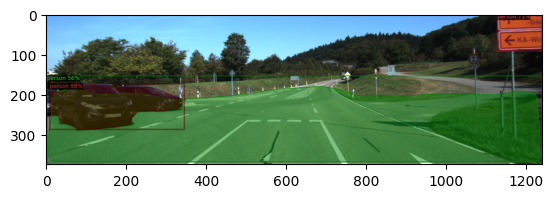

[04/26 02:55:27 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000008.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:55:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:28 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:37 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000008.png: detected 5 instances in 8.84s


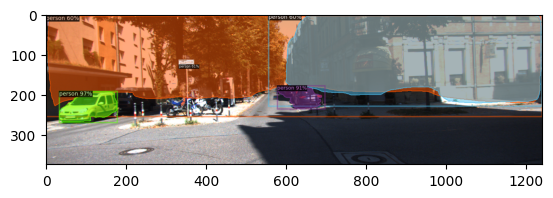

[04/26 02:55:38 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000011.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:55:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:39 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:50 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000011.png: detected 2 instances in 9.96s


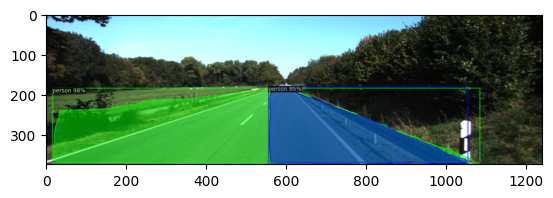

[04/26 02:55:50 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000006.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:55:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:55:53 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:00 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000006.png: detected 2 instances in 6.84s


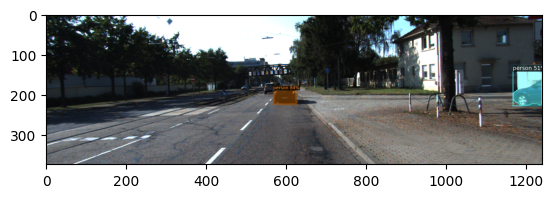

[04/26 02:56:00 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000004.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:56:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:02 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:10 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000004.png: detected 4 instances in 8.29s


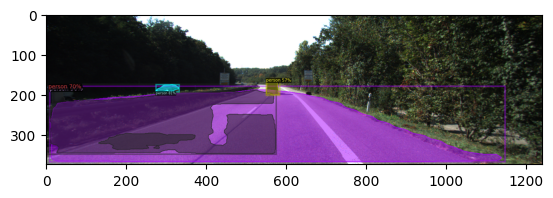

[04/26 02:56:11 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000017.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:56:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:12 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:20 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000017.png: detected 3 instances in 6.26s


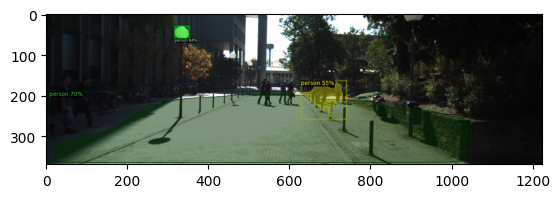

[04/26 02:56:20 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000016.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:56:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:22 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:31 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000016.png: detected 4 instances in 9.08s


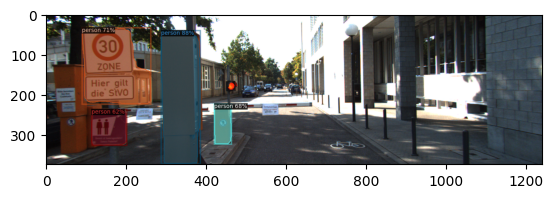

[04/26 02:56:32 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000009.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:56:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:33 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:41 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000009.png: detected 4 instances in 7.16s


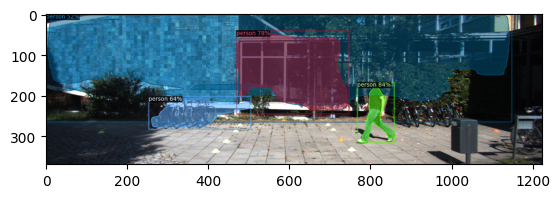

[04/26 02:56:41 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000015.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:56:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:44 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:53 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000015.png: detected 3 instances in 8.46s


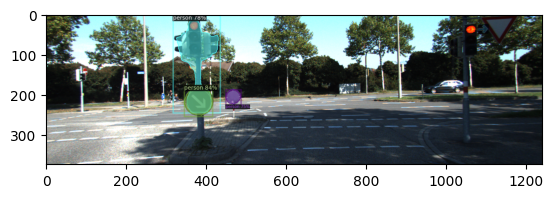

[04/26 02:56:53 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000007.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:56:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:56:55 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:07 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000007.png: detected 5 instances in 9.75s


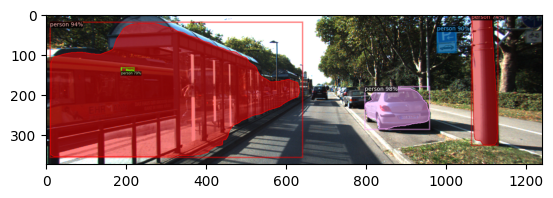

[04/26 02:57:07 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000005.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:57:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:08 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:17 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000005.png: detected 3 instances in 7.71s


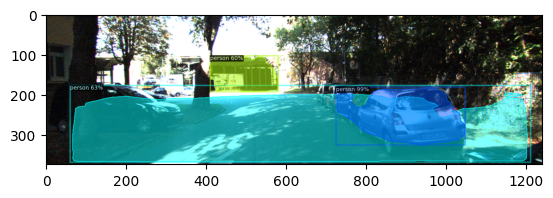

[04/26 02:57:17 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000013.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:57:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:19 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:27 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000013.png: detected 3 instances in 6.74s


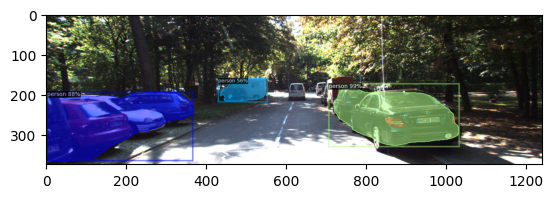

[04/26 02:57:27 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000014.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:57:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:28 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:38 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000014.png: detected 4 instances in 9.28s


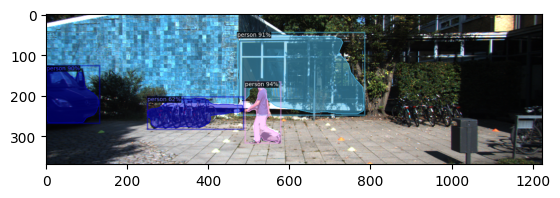

[04/26 02:57:39 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000021.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:57:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:40 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:47 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000021.png: detected 3 instances in 6.78s


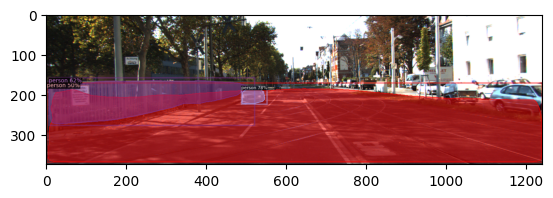

[04/26 02:57:48 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000002.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:57:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:50 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:57:58 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000002.png: detected 1 instances in 7.40s


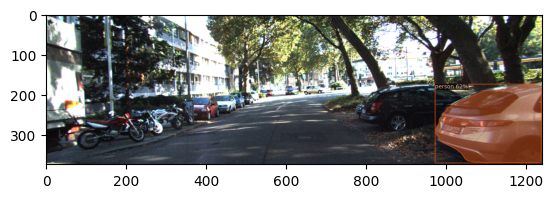

[04/26 02:57:58 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000019.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:58:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:00 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:10 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000019.png: detected 3 instances in 9.72s


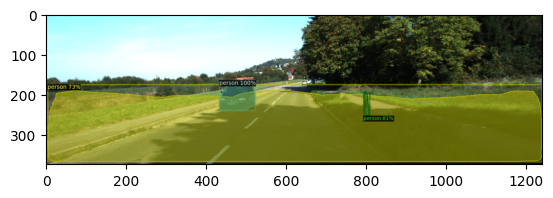

[04/26 02:58:10 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000018.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:58:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:11 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:19 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000018.png: detected 4 instances in 6.79s


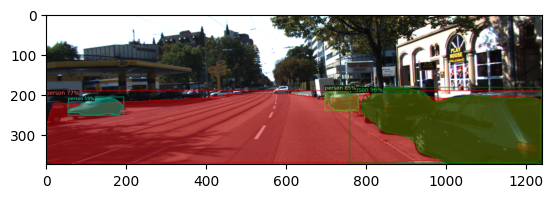

[04/26 02:58:19 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000022.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:58:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:21 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:30 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000022.png: detected 5 instances in 8.20s


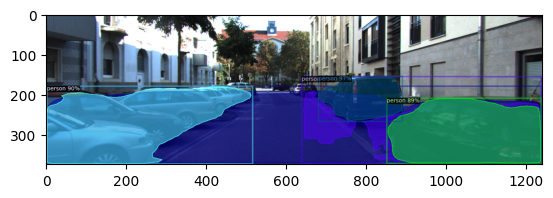

[04/26 02:58:30 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000023.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:58:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:32 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:42 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000023.png: detected 3 instances in 9.46s


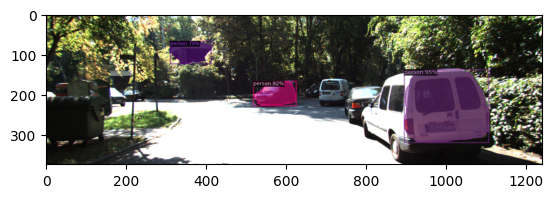

[04/26 02:58:42 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000020.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 02:58:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:43 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 02:58:50 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000020.png: detected 3 instances in 6.50s


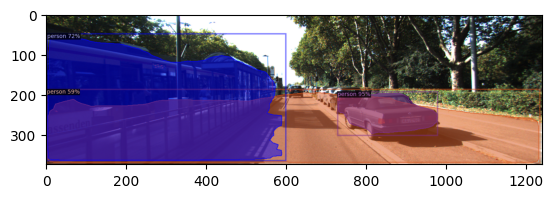

In [ ]:
directory_with_test_images = '/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2'
for filename in os.listdir(directory_with_test_images):
    f = os.path.join(directory_with_test_images, filename)
    deploy_detecter(input=f)

Try it yourself by defining paths to your images!

[04/26 03:13:44 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000116.png', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 03:13:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 03:13:45 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 03:13:52 detectron2]: /content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000116.png: detected 5 instances in 6.48s


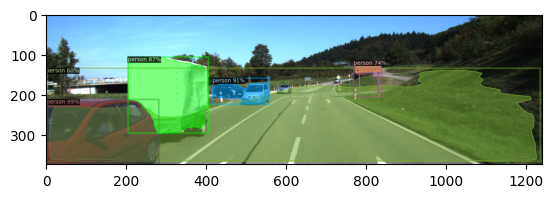

In [ ]:
deploy_detecter(input="/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/data_object_image_2/000116.png")

[04/26 03:29:01 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/7277DE55-BD51-4ADD-BC3E-CA96DBC5F5B0.JPG', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 03:29:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 03:29:08 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 03:29:34 detectron2]: /content/7277DE55-BD51-4ADD-BC3E-CA96DBC5F5B0.JPG: detected 27 instances in 21.66s


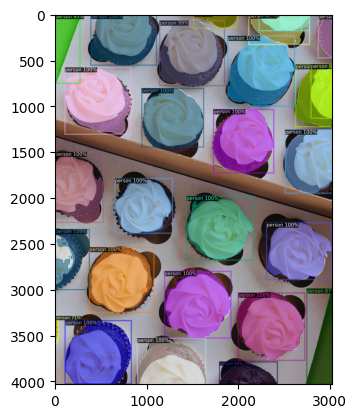

In [ ]:
deploy_detecter(input="/content/7277DE55-BD51-4ADD-BC3E-CA96DBC5F5B0.JPG")

[04/26 03:29:37 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/CD001E5F-61BF-464E-9B17-39F2193F233E.JPG', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 03:29:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 03:29:38 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 03:29:54 detectron2]: /content/CD001E5F-61BF-464E-9B17-39F2193F233E.JPG: detected 11 instances in 14.68s


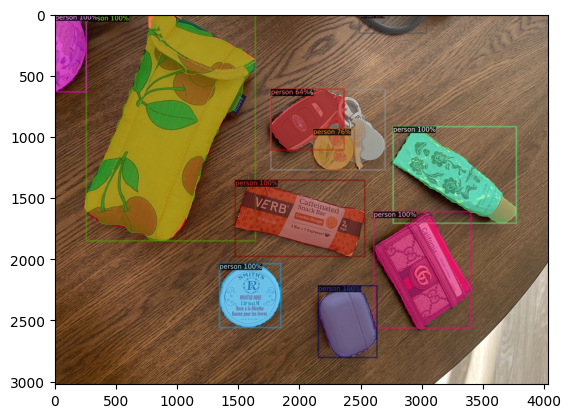

In [ ]:
deploy_detecter(input="/content/CD001E5F-61BF-464E-9B17-39F2193F233E.JPG")

[04/26 03:30:05 detectron2]: Arguments: Namespace(config_file='/content/drive/MyDrive/Colab Notebooks/CutLER/cutler/model_zoo/configs/CutLER-ImageNet/cascade_mask_rcnn_R_50_FPN.yaml', webcam=False, video_input=None, input='/content/D5E3312B-2657-4A73-A679-663F87E45CE3.JPG', output=None, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'cutler_cascade_final.pth', 'MODEL.DEVICE', 'cpu'])
[04/26 03:30:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from cutler_cascade_final.pth ...
[04/26 03:30:06 fvcore.common.checkpoint]: [Checkpointer] Loading from cutler_cascade_final.pth ...
[04/26 03:30:19 detectron2]: /content/D5E3312B-2657-4A73-A679-663F87E45CE3.JPG: detected 3 instances in 11.82s


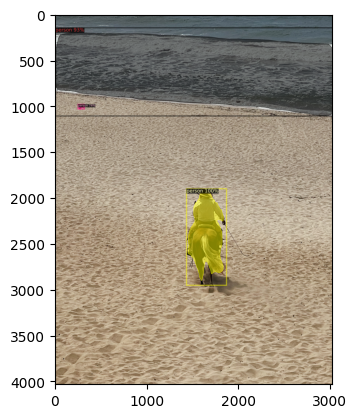

In [ ]:
deploy_detecter(input="/content/D5E3312B-2657-4A73-A679-663F87E45CE3.JPG")